In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64
BUFFER_SIZE = int(2e4)
MAX_LENGTH = 40 # Use the max_length to filter out examples with more than 40 tokens for faster training

## Setup input pipeline

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

The SubwordTextEncoder encodes the string by breaking it into subwords if the word is not in its dictionary. The whitespace ` ` will be used `_` to represent.

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples),
    target_vocab_size=2**13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.
7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


Add start and end token to the input and target. Here we use `vocab_size` to represents start token, `vocab_size + 1` to represents end token.

In [6]:
def encode(pt, en):
    pt = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(pt.numpy()) + [tokenizer_pt.vocab_size+1]
    en = [tokenizer_en.vocab_size] + tokenizer_en.encode(en.numpy()) + [tokenizer_en.vocab_size+1]
    return pt, en

# Warp the `encode` function to that it could be added to graph.
def tf_encode(pt, en):
    _pt, _en = tf.py_function(encode, inp=(pt, en), Tout=(tf.int64, tf.int64))
    _pt.set_shape = [None]
    _en.set_shape = [None]
    return _pt, _en

In [7]:
tf.size(tf.zeros((3, 5)))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [8]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    # tf.size returns the number of all elements in tensor.
    # e.g. shape of [3, 5] --> 15
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [9]:
train_dataset = train_examples.map(tf_encode) # string -> int64
train_dataset = train_dataset.filter(filter_max_length) # filters out examples with > 40 tokens
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length)
val_dataset = val_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))

In [10]:
pt_batch, en_batch = next(iter(train_dataset))
pt_batch.shape, en_batch.shape

(TensorShape([64, 38]), TensorShape([64, 40]))

## Positional encoding

In [11]:
def get_angle(pos, i, d_model):
    """
    Args:
        pos: word position.
        i: embedding_position.
        d_model: size of embedding.
    """
    # position-0: 10000**(0/d_model)
    # position-1: 10000**(0/d_model)
    # position-2: 10000**(2/d_model)
    # position-3: 10000**(2/d_model)
    # ...
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

In [12]:
def positional_encoding(sequence_length, d_model):
    angle_rads = get_angle(
        pos=np.arange(sequence_length)[:, np.newaxis], # [len_pos, 1]
        i=np.arange(d_model)[np.newaxis, :], # [1, d_model]
        d_model=d_model)
    
    # Apply sin to even indices in the array: 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # Apply cos to odd indices in the array: 2i+2
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...] # [1, len_pos, d_model]
    
    return tf.cast(pos_encoding, tf.float32)

(1, 30, 128)


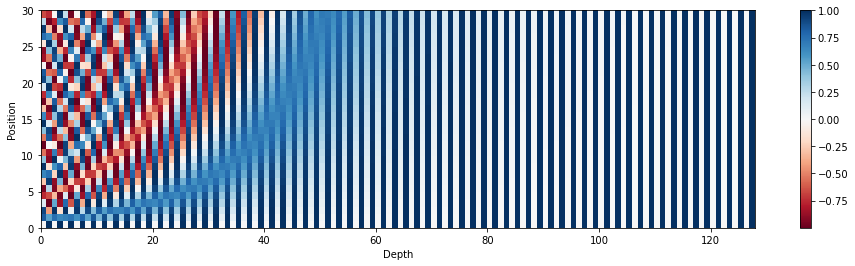

In [13]:
pos_encoding = positional_encoding(sequence_length=30, d_model=128)
print(pos_encoding.shape)

plt.figure(figsize=(16, 4))
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input.

In [14]:
def create_padding_mask(sequence):
    mask = tf.cast(tf.math.equal(sequence, 0), tf.float32)
    # Add extra dimensions to add the padding to the attention logits.
    return mask[:, tf.newaxis, tf.newaxis, :] # [BATCH_SIZE, 1, 1, seq_len] ([BATCH_SIZE, NUM_HEADS, seq_len_q, seq_len_k])

In [93]:
x = tf.constant([[7, 6, 0, 0, 1], [0, 6, 8, 0, 1]])
create_padding_mask(x)

<tf.Tensor: shape=(2, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[1., 0., 0., 1., 0.]]]], dtype=float32)>

Mask ahead words, which means that to predict the third word, only the first and second word will be used.

In [16]:
def create_look_ahead_mask(seq_len):
    # tf.linalg.band_part num_lower=-1 --> Lower triangular part.
    # tf.linalg.band_part num_upper=0 --> Diagonal.
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), num_lower=-1, num_upper=0)
    return mask

In [17]:
create_look_ahead_mask(3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

![](https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png)

In [18]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matchin penultimate dimension, i.e.: seq_len_k = seq_len_v
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.
    
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None
    
    Returns:
        output, attention_weights
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    depth_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(depth_k) # (..., seq_len_q, seq_len_k)
    
    # Add the mask to the scaled attention logits.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
        
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # (..., seq_len_q, seq_len_k)
    
    context = tf.matmul(attention_weights, v) # (..., seq_len_q, depth_v)
    
    return context, attention_weights

In [19]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)


np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`, so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [20]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [21]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [22]:
# All together
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

![image.png](https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png)

Contains:
- Linear layers and split into heads.
- Scaled dot-product attention.
- Concatenation of heads.
- Final linear layer.

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        # depth for each head
        self.depth = d_model // self.num_heads
        
        self.Wq = tf.keras.layers.Dense(d_model)
        self.Wk = tf.keras.layers.Dense(d_model)
        self.Wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the late dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        
        Args:
            x: original input, of shape (batch_size, seq_len, d_model)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.Wq(q) # (batch_size, seq_len_q, d_model)
        k = self.Wq(k) # (batch_size, seq_len_k, d_model)
        v = self.Wq(v) # (batch_size, seq_len_v, d_model)
        
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (batch_size, seq_len_q, num_heads, depth)
        concate_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))# (batch_size, seq_len_q, d_model)
        
        output = self.dense(concate_attention) # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

In [24]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
output, attention_weights = temp_mha(y, k=y, q=y, mask=None)
output.shape, attention_weights.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [25]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'), # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model) # (batch_size, seq_len, d_model)
    ])

In [29]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

![image.png](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

### Encoder layer

consists:
- Multi-head attention (with padding mask)
- Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        
        # The lower part
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output) # (batch_size, input_seq_len, d_model)
        
        # The upper part
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2

In [34]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 40, 512)), training=False, mask=None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 40, 512])

### Decoder layer

consists:
- Masked multi-head attention (with look ahead mask and padding mask)
- Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
- Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization.

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        
        # The lower part
        attn1, atten_weights_block1 = self.mha1(x, x, x, look_ahead_mask) # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # (batch_size, target_seq_len, d_model)
        
        # The middle part
        attn2, atten_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1) # (batch_size, target_seq_len, d_model)
        
        # The upper part
        ffn_output = self.ffn(out2) # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, d_model)
        
        return out3, atten_weights_block1, atten_weights_block2
        

In [39]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    x=tf.random.uniform((64, 50, 512)),
    enc_output=sample_encoder_layer_output, 
    training=False,
    look_ahead_mask=None,
    padding_mask=None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

consist:
- Input Embedding
- Positional Embedding
- N Encoder layers

In [41]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.d_model) # (batch_size, input_seq_len, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model) # (1, max_pos_enc, d_model)
        
        self.enc_layers = [EncoderLayer(self.d_model, num_heads, dff, rate) for _ in range(self.num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        
        seq_len = tf.shape(x)[1]
        
        # Adding embedding and position encoding.
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        # The reason we increase the embedding values before the addition is to make 
        #   the positional encoding relatively smaller. This means the original meaning 
        #   in the embedding vector won’t be lost when we add them together.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for _ in range(self.num_layers):
            x = self.enc_layers[_](x, training=training, mask=mask)
            
        return x # (batch_size, input_seq_len, d_model)

In [42]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

In [52]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1, **kwargs):
        super(Decoder, self).__init__(**kwargs)

        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.dec_layers = [DecoderLayer(self.d_model, num_heads, dff, rate) for _ in range(self.num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x) # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for _ in range(self.num_layers):
            x, block1, block2 = self.dec_layers[_](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1'.format(_+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(_+1)] = block2
            
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [53]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the transformer

In [55]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1, **kwargs):
        super(Transformer, self).__init__(**kwargs)
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, targ, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask) # (batch_size, input_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            targ, enc_output, training, look_ahead_mask, dec_padding_mask) # (batch_size, target_seq_len ,d_model)
        
        final_output = self.final_layer(dec_output) # (batch_size, target_seq_len, target_vocab_size)
        
        return final_output, attention_weights

In [56]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

In [86]:
NUM_LAYERS = 8
D_MODEL = 128
DFF = 512
NUM_HEADS = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

In [77]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super(CustomSchedule, self).__init__(**kwargs)
        
        self.d_model = tf.cast(d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [80]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

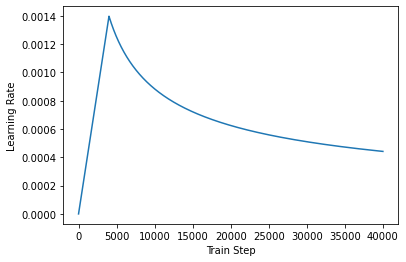

In [82]:
temp_learning_rate_schedule = CustomSchedule(D_MODEL)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

In [83]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [84]:
def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    mask = tf.cast(tf.math.not_equal(real, 0), loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask) # each token loss

In [85]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## Train and checkpointing

In [114]:
transformer = Transformer(NUM_LAYERS, D_MODEL, NUM_HEADS, DFF,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [104]:
def create_mask(inp, targ):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
    
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(targ)[1]) # [target_seq_len, target_seq_len]
    dec_target_padding_mask = create_padding_mask(targ) # [BATCH_SIZE, 1, 1, target_seq_len]
    combind_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) # [BATCH_SIZE, 1, target_seq_len, target_seq_len]
    
    return enc_padding_mask, combind_mask, dec_padding_mask

In [105]:
checkpoint_path = './checkpoint/train'

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` = "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [117]:
EPOCHS = 20

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # (batch_size, target_seq_len - 1)
    tar_real = tar[:, 1:] # (batch_size, target_seq_len - 1)

    enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     training=True, 
                                     enc_padding_mask=enc_padding_mask,
                                     look_ahead_mask=combined_mask,
                                     dec_padding_mask=dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [130]:
for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # inp -> portuguese, targ -> english
    for (batch_idx, (inp, targ)) in enumerate(train_dataset):
        train_step(inp, targ)
        
        if batch_idx % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1, batch_idx, train_loss.result(), train_accuracy.result()))
            
    if epoch % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1, train_loss.result(), train_accuracy.result()))
    print('Time taken for 1 epoch: {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0165 Accuracy 0.0000
Epoch 1 Batch 50 Loss 7.0034 Accuracy 0.0248
Epoch 1 Batch 100 Loss 6.7617 Accuracy 0.0258
Epoch 1 Batch 150 Loss 6.6741 Accuracy 0.0261
Epoch 1 Batch 200 Loss 6.6318 Accuracy 0.0263
Epoch 1 Batch 250 Loss 6.6035 Accuracy 0.0265
Epoch 1 Batch 300 Loss 6.5829 Accuracy 0.0266
Epoch 1 Batch 350 Loss 6.5672 Accuracy 0.0266
Epoch 1 Batch 400 Loss 6.5588 Accuracy 0.0266
Epoch 1 Batch 450 Loss 6.5513 Accuracy 0.0266
Epoch 1 Batch 500 Loss 6.5439 Accuracy 0.0267
Epoch 1 Batch 550 Loss 6.5376 Accuracy 0.0267
Epoch 1 Batch 600 Loss 6.5322 Accuracy 0.0267
Epoch 1 Batch 650 Loss 6.5269 Accuracy 0.0267
Epoch 1 Batch 700 Loss 6.5228 Accuracy 0.0268
Saving checkpoint for epoch 1 at ./checkpoint/train/ckpt-5
Epoch 1 Loss 6.5225 Accuracy 0.0268
Time taken for 1 epoch: 90.27151536941528 sec

Epoch 2 Batch 0 Loss 6.4266 Accuracy 0.0274
Epoch 2 Batch 50 Loss 6.4615 Accuracy 0.0271
Epoch 2 Batch 100 Loss 6.4634 Accuracy 0.0272
Epoch 2 Batch 150 Loss 6.4532 Accura

Epoch 11 Batch 400 Loss 6.1885 Accuracy 0.0434
Epoch 11 Batch 450 Loss 6.1890 Accuracy 0.0435
Epoch 11 Batch 500 Loss 6.1890 Accuracy 0.0434
Epoch 11 Batch 550 Loss 6.1902 Accuracy 0.0435
Epoch 11 Batch 600 Loss 6.1923 Accuracy 0.0435
Epoch 11 Batch 650 Loss 6.1918 Accuracy 0.0435
Epoch 11 Batch 700 Loss 6.1924 Accuracy 0.0435
Saving checkpoint for epoch 11 at ./checkpoint/train/ckpt-7
Epoch 11 Loss 6.1925 Accuracy 0.0435
Time taken for 1 epoch: 74.77364444732666 sec

Epoch 12 Batch 0 Loss 6.2430 Accuracy 0.0421
Epoch 12 Batch 50 Loss 6.1678 Accuracy 0.0442
Epoch 12 Batch 100 Loss 6.1807 Accuracy 0.0437
Epoch 12 Batch 150 Loss 6.1826 Accuracy 0.0435
Epoch 12 Batch 200 Loss 6.1816 Accuracy 0.0435
Epoch 12 Batch 250 Loss 6.1821 Accuracy 0.0435
Epoch 12 Batch 300 Loss 6.1832 Accuracy 0.0433
Epoch 12 Batch 350 Loss 6.1845 Accuracy 0.0434
Epoch 12 Batch 400 Loss 6.1855 Accuracy 0.0435
Epoch 12 Batch 450 Loss 6.1850 Accuracy 0.0434
Epoch 12 Batch 500 Loss 6.1857 Accuracy 0.0435
Epoch 12 Batc

## Evaluate

In [144]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    
    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
    
    # as the target is english, the first word to the transformer should be english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_mask(encoder_input, output)
        
        # predictions.shape == [batch_size(1), seq_len, vocab_size]
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :] # [batch_size(1), 1, vocab_size]
        
        prediction_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32) # [batch_size(1), 1]
        
        # return the result if the predicted_id is equal to the end token
        if prediction_id == tokenizer_en.vocab_size + 1:
            return tf.squeeze(output, axis=0), attention_weights
        else:
            output = tf.concat([output, prediction_id], axis=-1)
            
    return tf.squeeze(output, axis=0), attention_weights

In [145]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [146]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [147]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: thank thank 
Real translation: this is a problem we have to solve .


In [148]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: thank 
Real translation: and my neighboring homes heard about this idea .


In [149]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: thank 
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted translation: thank thank 


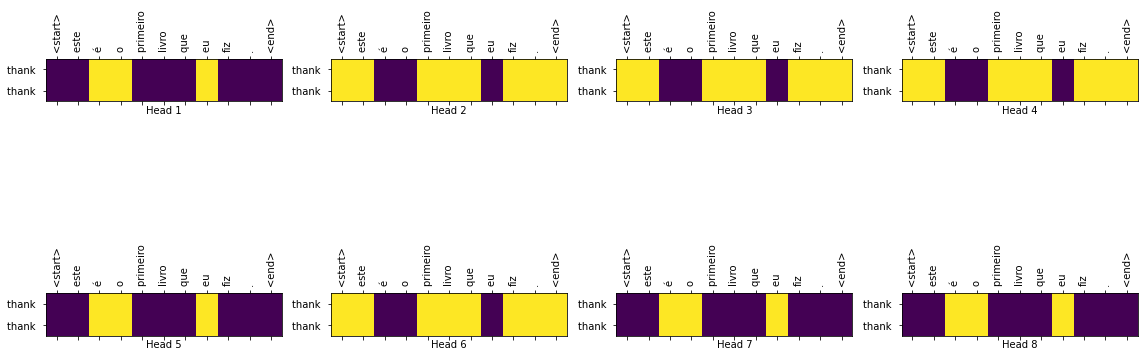

Real translation: this is the first book i've ever done.


In [150]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")